### Import Modules

In [95]:
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import os

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hrenik2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hrenik2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hrenik2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Global Variables

In [96]:
DATASET_DIR  = "C:/Users/hrenik2/Desktop/Folders/CS583/Project/"
DATA_COLUMNS = [1, 2, 3, 4]
CLASS_VALUES = ['-1', '0', '1']
RANDOM_STATE =  42

## Data Load

In [97]:
obama_data  = pd.read_excel(DATASET_DIR + 'training-Obama-Romney-tweets.xlsx', sheet_name= 'Obama', usecols= DATA_COLUMNS, skiprows = 2, header = None, converters = {4 : str})
romney_data = pd.read_excel(DATASET_DIR + 'training-Obama-Romney-tweets.xlsx', sheet_name= 'Romney', usecols= DATA_COLUMNS, skiprows = 2, header = None, converters = {4 : str})

In [98]:
obama_data.head()

,1,2,3,4
0,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0
1,2016-12-10 00:00:00,10:09:00-05:00,Question: If <e>Romney</e> and <e>Obama</e> ha...,2
2,2012-10-16 00:00:00,10:04:30-05:00,#<e>obama</e> debates that Cracker Ass Cracker...,1
3,2012-10-16 00:00:00,10:00:36-05:00,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2
4,2012-10-16 00:00:00,09:50:08-05:00,@Hollivan @hereistheanswer Youre missing the ...,0


## Write Results to File

In [99]:
def write_output(output_file_name, labels):
    with open(output_file_name, 'w') as output_file:
        for index, value in enumerate(labels):
            if value == 0:
                y = -1
            elif value == 1:
                y = 0
            elif value ==2:
                y = 1
            output_file.write(f'{index+1};;{y}\n')

## Data Cleaning

In [100]:
def train_data_clean(df):
    '''Function to clean the training data'''
    # Drop unnecessary columns and rename header for tweets and class columns
    df  = df.drop([1, 2], axis = 'columns').rename({3 : 'tweet_text', 4 : 'class'}, axis = 1)
    # Remove rows having missing values
    df.dropna(axis = 0, inplace = True)
    # Remove classes other than (-1, 0, 1)
    df.drop(df[~df['class'].isin(CLASS_VALUES)].index, inplace = True)
    # Update the class labels to numeric type
    df.replace({'-1' : -1, '0': 0, '1' : 1}, inplace = True)
    return df

def test_data_clean(df):
    '''Function to clean the testing data'''
    # Drop unnecessary columns and rename header for tweets and id columns
    df  = df.rename({0 : 'tweet_id', 1 : 'tweet_text'}, axis = 1)
    # Remove rows having missing values
    df.dropna(axis = 0, inplace = True)
    return df

,tweet_text,class
219,mitt romney say catch bin lade would insignifi...,-1
392,scene wh morning really debate govv romney eff...,-1
134,city thank god never anything roman romney one...,-1
710,accidently like mitt romney facebook purposely...,-1
2087,romney puppet ryan actually qualify run oval o...,-1
...,...,...
3337,romney go office might well go back slave society,-1
226,adwatch mitt romney wrong women health radioat...,-1
1757,romney win mean no food stamp mean ghetto go h...,-1
7041,not believe romney keep cut obama woulda punch...,-1


In [101]:
obama_data = train_data_clean(obama_data)
romney_data = train_data_clean(romney_data)
# Added to balance the classes
# romney_data = romney_data.groupby('class').sample(1075)

In [102]:
romney_data.head()

,tweet_text,class
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
2,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
3,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
4,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1
5,Hope <e>Romney</e> debate prepped w/ the same ...,1


##  Data Analysis

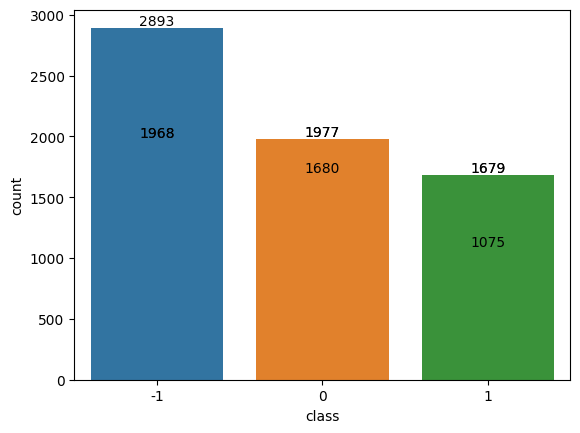

In [103]:
obama_data['class'].value_counts(), romney_data['class'].value_counts()
o_plt = sns.countplot(x = obama_data['class'])
for i in o_plt.containers:
    o_plt.bar_label(i,)
r_plt = sns.countplot(x = romney_data['class'])
for i in r_plt.containers:
    r_plt.bar_label(i,)

## Data Preprocessing

In [104]:
def remove_HTML_tags(text):
    '''Function to remove HTML tags from text'''
    soup = BeautifulSoup(text, "html.parser")  
    for data in soup(['style', 'script']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

def remove_URL(text):
    '''Function to remove URLs from text'''
    return re.sub(r"http\S+", "", text)

def remove_hastags_mentions(text):
    '''Function to remove the Hashtags and mentions from text'''
    entities = ['@', '#']
    clean_words = [word for word in text.split() if word[0] not in entities]
    return ' '.join(clean_words)

def remove_punctuations(text):
    '''Function to remove punctations from text'''
    for punc in string.punctuation:
        text = text.replace(punc,'') 
    return re.sub('[^A-Za-z\s]', '', text)

def decontract_text(text):
    '''Funtion to expand words that are in short forms'''
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'d", " had", text)
    text = re.sub(r"\'m", " am", text)
    return text

def remove_stopwords(text):
    '''Function to remove stopwords from text'''
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('won')
    stopwords.remove("nor")
    stopwords.remove("not")
    stopwords.remove("no")
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)

def stemming(text):
    '''Function to perform stemming on words of text'''
    snowball_stemmer = SnowballStemmer('english')
    words = [snowball_stemmer.stem(word) for word in text.split()]
    return ' '.join(words)

def lemmatization(text):
    '''Function to perform lemmatization on words of text'''
    wordnet_lemmatizer = WordNetLemmatizer()
    words = [wordnet_lemmatizer.lemmatize(word, pos = "v") for word in text.split()]
    return ' '.join(words)

def preprocess_text(text):
    '''Function to perform all the preprocessing steps for given text'''
    text = text.lower()                   
    text = remove_HTML_tags(text)
    text = remove_URL(text)
    text = remove_hastags_mentions(text)
    text = decontract_text(text)
    text = remove_punctuations(text)
    # text = stemming(text)              # removed stemming (ex case: baseball - basebal) # achieved better results w/o stemming
    text = lemmatization(text)
    text = remove_stopwords(text)
    return text

In [105]:
obama_data['tweet_text']  = obama_data['tweet_text'].apply(preprocess_text)
romney_data['tweet_text'] = romney_data['tweet_text'].apply(preprocess_text)

c:\Users\hrenik2\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## Test Data Logic

In [106]:
# Data Load
obama_test_data  = pd.read_excel(DATASET_DIR + 'final-testData-no-label-Obama-tweets.xlsx', sheet_name= 'Obama', usecols= [0, 1], skiprows = 0, header = None)
romney_test_data = pd.read_excel(DATASET_DIR + 'final-testData-no-label-Romney-tweets.xlsx', sheet_name= 'Romney', usecols= [0, 1], skiprows = 0, header = None)

# Data Cleaning
obama_test_data = test_data_clean(obama_test_data)
romney_test_data = test_data_clean(romney_test_data)

# Data Preprocessing
obama_test_data['tweet_text']  = obama_test_data['tweet_text'].apply(preprocess_text)
romney_test_data['tweet_text'] = romney_test_data['tweet_text'].apply(preprocess_text)

c:\Users\hrenik2\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [107]:
obama_test_data.head()

,tweet_id,tweet_text
0,1,obama maintain professionalism throughout enti...
1,2,obama go debate swing come bang job president
2,3,ditto start years ago rt work small business s...
3,4,absolutely love obama view immigration really ...
4,5,agree completely obama stance immigration let ...


## Test Train Split

In [108]:
print("Size of Obama dataset is  : ", obama_data.shape)
print("Size of Romeny dataset is : ", romney_data.shape)
print("Size of Obama test dataset is  : ", obama_test_data.shape)
print("Size of Romeny test dataset is : ", romney_test_data.shape)

Size of Obama dataset is  :  (5624, 2)
Size of Romeny dataset is :  (5648, 2)
Size of Obama test dataset is  :  (1951, 2)
Size of Romeny test dataset is :  (1900, 2)


In [109]:
# Obama train_test_split
X_obama = obama_data['tweet_text']
y_obama = obama_data['class']
X_train_obama, X_test_obama, y_train_obama = X_obama, obama_test_data['tweet_text'], y_obama 


# Romney train_test_split
X_romney = romney_data['tweet_text']
y_romney = romney_data['class']
X_train_romney, X_test_romney, y_train_romney = X_romney, romney_test_data['tweet_text'], y_romney


In [60]:
# # Obama train_test_split
# X_obama = obama_data['tweet_text']
# y_obama = obama_data['class']
# X_train_obama, X_test_obama, y_train_obama, y_test_obama = train_test_split(X_obama, 
#                                                                             y_obama,
#                                                                             test_size = 0.10,
#                                                                             random_state = RANDOM_STATE,
#                                                                             shuffle = True,
#                                                                             stratify = y_obama)

# X_train_obama, X_cv_obama, y_train_obama, y_cv_obama = train_test_split(X_train_obama,
#                                                                         y_train_obama,
#                                                                         test_size = 0.10,
#                                                                         random_state = RANDOM_STATE,
#                                                                         shuffle = True,
#                                                                         stratify = y_train_obama)

# print('Shapes of train, cross validate, and test data of Obama :')
# print('X_train shape : ', X_train_obama.shape,',  y_train shape : ', y_train_obama.shape)
# print('X_cv shape    : ', X_cv_obama.shape,   ',  y_cv shape    : ', y_cv_obama.shape)
# print('X_test shape  : ', X_test_obama.shape, ',  y_test shape  : ', y_test_obama.shape)

# # Romney train_test_split
# X_romney = romney_data['tweet_text']
# y_romney = romney_data['class']
# X_train_romney, X_test_romney, y_train_romney, y_test_romney = train_test_split(X_romney, 
#                                                                                 y_romney,
#                                                                                 test_size = 0.10,
#                                                                                 random_state = RANDOM_STATE,
#                                                                                 shuffle = True,
#                                                                                 stratify = y_romney)

# X_train_romney, X_cv_romney, y_train_romney, y_cv_romney = train_test_split(X_train_romney,
#                                                                             y_train_romney,
#                                                                             test_size = 0.10,
#                                                                             random_state = RANDOM_STATE,
#                                                                             shuffle = True,
#                                                                             stratify = y_train_romney)

# print('\nShapes of train, cross validate, and test data of Romney :')
# print('X_train shape : ', X_train_romney.shape,',  y_train shape : ', y_train_romney.shape)
# print('X_cv shape    : ', X_cv_romney.shape,   ',  y_cv shape    : ', y_cv_romney.shape)
# print('X_test shape  : ', X_test_romney.shape, ',  y_test shape  : ', y_test_romney.shape)

## Feature Engineering

### Label Encoding

In [110]:
# LABEL ENCODING
label_encoder = LabelEncoder()
y_train_enc_obama = label_encoder.fit_transform(y_train_obama)
# y_cv_enc_obama    = label_encoder.fit_transform(y_cv_obama)
# y_test_enc_obama  = label_encoder.fit_transform(y_test_obama)

y_train_enc_romney = label_encoder.fit_transform(y_train_romney)
# y_cv_enc_romney    = label_encoder.fit_transform(y_cv_romney)
# y_test_enc_romney  = label_encoder.fit_transform(y_test_romney)

### Sentiment Intensity Analyser for text

In [111]:
sid = SentimentIntensityAnalyzer()
X_train_sid_obama = [list(sid.polarity_scores(x).values()) for x in X_train_obama]
# X_cv_sid_obama    = [list(sid.polarity_scores(x).values()) for x in X_cv_obama]
X_test_sid_obama  = [list(sid.polarity_scores(x).values()) for x in X_test_obama]

X_train_sid_romney = [list(sid.polarity_scores(x).values()) for x in X_train_romney]
# X_cv_sid_romney    = [list(sid.polarity_scores(x).values()) for x in X_cv_romney]
X_test_sid_romney  = [list(sid.polarity_scores(x).values()) for x in X_test_romney]

### TF-IDF

In [112]:
X_train_obama.iloc[0]

'kirkpatrick wear baseball cap embroider barack obama signature hangdog look jason segel courier journal'

In [113]:
# Create TF-IDF feature matrix for the processed tweet_text

tfidf_vectorizer_obama = TfidfVectorizer(min_df = 2)
X_train_tfidf_obama = tfidf_vectorizer_obama.fit_transform(X_train_obama)
X_test_tfidf_obama  = tfidf_vectorizer_obama.transform(X_test_obama)
print("Shape of TF-IDF train, test feature matrices of Obama  : ", X_train_tfidf_obama.shape, "", X_test_tfidf_obama.shape)
# X_cv_tfidf_obama   = tfidf_vectorizer_obama.transform(X_cv_obama)
# print("Shape of TF-IDF train, cv, test feature matrices of Obama  : ", X_train_tfidf_obama.shape, "", X_cv_tfidf_obama.shape, "", X_test_tfidf_obama.shape)

tfidf_vectorizer_romney = TfidfVectorizer(min_df = 2)
X_train_tfidf_romney = tfidf_vectorizer_romney.fit_transform(X_train_romney)
X_test_tfidf_romney  = tfidf_vectorizer_romney.transform(X_test_romney)
print("Shape of TF-IDF train, test feature matrices of Romney : ", X_train_tfidf_romney.shape, "", X_test_tfidf_romney.shape)
# X_cv_tfidf_romney    = tfidf_vectorizer_romney.transform(X_cv_romney)
# # print("Shape of TF-IDF train, cv, test feature matrices of Romney : ", X_train_tfidf_romney.shape, "", X_cv_tfidf_romney.shape, "", X_test_tfidf_romney.shape)

Shape of TF-IDF train, test feature matrices of Obama  :  (5624, 3061)  (1951, 3061)
Shape of TF-IDF train, test feature matrices of Romney :  (5648, 2977)  (1900, 2977)


### Word2Vec

In [66]:
# import gensim.downloader as api
# print(list(gensim.downloader.info()['models'].keys()))

In [114]:
# Get word embeddings from pre-trained model 'glove-twitter-200.kv'
if not os.path.exists(DATASET_DIR + 'glove-twitter-200.kv'):
    w2v_model = api.load('glove-twitter-200')
    w2v_model.save(DATASET_DIR + 'glove-twitter-200.kv')
else:
    w2v_model = KeyedVectors.load(DATASET_DIR + 'glove-twitter-200.kv')

# Get word embeddings from pre-trained model 'word2vec-google-news-300.kv'
if not os.path.exists(DATASET_DIR + 'word2vec-google-news-300.kv'):
    w2v_model300 = api.load('word2vec-google-news-300')
    w2v_model300.save(DATASET_DIR + 'word2vec-google-news-300.kv')
else:
    w2v_model300 = KeyedVectors.load(DATASET_DIR + 'word2vec-google-news-300.kv')

In [115]:
def create_word2vec_features(text):
    vector_size = w2v_model.vector_size
    vec = np.zeros(vector_size)
    word_count = 0
    for word in text.split():
        if word in w2v_model:
            vec += w2v_model[word]
            word_count += 1
    if word_count != 0:
        vec /= word_count
    return vec

def create_word2vec300_features(text):
    vector_size = w2v_model300.vector_size
    vec = np.zeros(vector_size)
    word_count = 0
    for word in text.split():
        if word in w2v_model300:
            vec += w2v_model300[word]
            word_count += 1
    if word_count != 0:
        vec /= word_count
    return vec

In [116]:
X_train_w2v_obama = np.hstack([X_train_obama.apply(create_word2vec_features).to_list(), X_train_sid_obama])
X_test_w2v_obama  = np.hstack([X_test_obama.apply(create_word2vec_features).to_list(), X_test_sid_obama])
# X_cv_w2v_obama    = np.hstack([X_cv_obama.apply(create_word2vec_features).to_list(), X_cv_sid_obama])

X_train_w2v_romney = np.hstack([X_train_romney.apply(create_word2vec_features).to_list(), X_train_sid_romney])
X_test_w2v_romney  = np.hstack([X_test_romney.apply(create_word2vec_features).to_list(), X_test_sid_romney])
# X_cv_w2v_romney    = np.hstack([X_cv_romney.apply(create_word2vec_features).to_list(), X_cv_sid_romney])

In [117]:
X_train_w2v300_obama = np.hstack([X_train_obama.apply(create_word2vec300_features).to_list(), X_train_sid_obama])
X_test_w2v300_obama  = np.hstack([X_test_obama.apply(create_word2vec300_features).to_list(), X_test_sid_obama])
# X_cv_w2v300_obama    = np.hstack([X_cv_obama.apply(create_word2vec300_features).to_list(), X_cv_sid_obama])

X_train_w2v300_romney = np.hstack([X_train_romney.apply(create_word2vec300_features).to_list(), X_train_sid_romney])
X_test_w2v300_romney  = np.hstack([X_test_romney.apply(create_word2vec300_features).to_list(), X_test_sid_romney])
# X_cv_w2v300_romney    = np.hstack([X_cv_romney.apply(create_word2vec300_features).to_list(), X_cv_sid_romney])
# len(X_train_w2v300_obama[0]), len(np.hstack([X_train_obama.apply(create_word2vec300_features)[0], X_train_sid_obama[0]]))

### TF-IDF with Word2Vec

In [118]:
# Obama tf-idf with word2vec
idf_dict_obama = dict(zip(tfidf_vectorizer_obama.get_feature_names_out(), list(tfidf_vectorizer_obama.idf_)))
tfidf_words_obama = set(tfidf_vectorizer_obama.get_feature_names_out())

def create_tfidf_word2vec300_features_obama(text):
    vector_size = w2v_model300.vector_size
    vec = np.zeros(vector_size)
    tfidf_wt = 0
    for word in text.split():
        if (word in w2v_model300) and (word in tfidf_words_obama):
            tfidf = idf_dict_obama[word]*((text.count(word))/(len(text.split())))
            vec += (w2v_model300[word] * tfidf)
            tfidf_wt += tfidf
    if tfidf_wt != 0:
        vec /= tfidf_wt
    return vec


# Romney tf-idf with word2vec
idf_dict_romney = dict(zip(tfidf_vectorizer_romney.get_feature_names_out(), list(tfidf_vectorizer_romney.idf_)))
tfidf_words_romney = set(tfidf_vectorizer_romney.get_feature_names_out())

def create_tfidf_word2vec300_features_romney(text):
    vector_size = w2v_model300.vector_size
    vec = np.zeros(vector_size)
    tfidf_wt = 0
    for word in text.split():
        if (word in w2v_model300) and (word in tfidf_words_romney):
            tfidf = idf_dict_romney[word]*((text.count(word))/(len(text.split())))
            vec += (w2v_model300[word] * tfidf)
            tfidf_wt += tfidf
    if tfidf_wt != 0:
        vec /= tfidf_wt
    return vec

In [119]:
X_train_tfidf_w2v300_obama = np.hstack([X_train_obama.apply(create_tfidf_word2vec300_features_obama).to_list(), X_train_sid_obama])
X_test_tfidf_w2v300_obama  = np.hstack([X_test_obama.apply(create_tfidf_word2vec300_features_obama).to_list(), X_test_sid_obama])
# X_cv_tfidf_w2v300_obama    = np.hstack([X_cv_obama.apply(create_tfidf_word2vec300_features_obama).to_list(), X_cv_sid_obama])

X_train_tfidf_w2v300_romney = np.hstack([X_train_romney.apply(create_tfidf_word2vec300_features_romney).to_list(), X_train_sid_romney])
X_test_tfidf_w2v300_romney  = np.hstack([X_test_romney.apply(create_tfidf_word2vec300_features_romney).to_list(), X_test_sid_romney])
# X_cv_tfidf_w2v300_romney    = np.hstack([X_cv_romney.apply(create_tfidf_word2vec300_features_romney).to_list(), X_cv_sid_romney])

## Model Testing

### XGBClassifier

In [24]:
# #### OBAMA DATA ####
# xgb_classifier_tfidf = XGBClassifier()
# xgb_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# # Prediction
# xgb_tfidf_cv_pred_obama   = xgb_classifier_tfidf.predict(X_cv_tfidf_obama)
# xgb_tfidf_test_pred_obama = xgb_classifier_tfidf.predict(X_test_tfidf_obama)
# # Evaluation Metrics
# print("Obama XGB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_tfidf_cv_pred_obama), accuracy_score(y_test_enc_obama, xgb_tfidf_test_pred_obama))
# print(classification_report(y_test_enc_obama, xgb_tfidf_test_pred_obama))


# xgb_classifier_w2v = XGBClassifier()
# xgb_classifier_w2v.fit(X_train_w2v_obama, y_train_enc_obama)
# # Prediction
# xgb_w2v_cv_pred_obama   = xgb_classifier_w2v.predict(X_cv_w2v_obama)
# xgb_w2v_test_pred_obama = xgb_classifier_w2v.predict(X_test_w2v_obama)
# # Evaluation Metrics
# print("Obama XGB W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_w2v_cv_pred_obama), accuracy_score(y_test_enc_obama, xgb_w2v_test_pred_obama))
# print(classification_report(y_test_enc_obama, xgb_w2v_test_pred_obama))


# xgb_classifier_w2v300 = XGBClassifier()
# xgb_classifier_w2v300.fit(X_train_w2v300_obama, y_train_enc_obama)
# # Prediction
# xgb_w2v300_cv_pred_obama   = xgb_classifier_w2v300.predict(X_cv_w2v300_obama)
# xgb_w2v300_test_pred_obama = xgb_classifier_w2v300.predict(X_test_w2v300_obama)
# # Evaluation Metrics
# print("Obama XGB W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_w2v300_cv_pred_obama), accuracy_score(y_test_enc_obama, xgb_w2v300_test_pred_obama))
# print(classification_report(y_test_enc_obama, xgb_w2v300_test_pred_obama))


# xgb_classifier_tfidf_w2v300 = XGBClassifier()
# xgb_classifier_tfidf_w2v300.fit(X_train_tfidf_w2v300_obama, y_train_enc_obama)
# # Prediction
# xgb_tfidf_w2v300_cv_pred_obama   = xgb_classifier_tfidf_w2v300.predict(X_cv_tfidf_w2v300_obama)
# xgb_tfidf_w2v300_test_pred_obama = xgb_classifier_tfidf_w2v300.predict(X_test_tfidf_w2v300_obama)
# # Evaluation Metrics
# print("Obama XGB TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_tfidf_w2v300_cv_pred_obama), accuracy_score(y_test_enc_obama, xgb_tfidf_w2v300_test_pred_obama))
# print(classification_report(y_test_enc_obama, xgb_tfidf_w2v300_test_pred_obama))




# #### ROMNEY DATA ####
# xgb_classifier_tfidf_r = XGBClassifier()
# xgb_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# # Prediction
# xgb_tfidf_cv_pred_romney   = xgb_classifier_tfidf_r.predict(X_cv_tfidf_romney)
# xgb_tfidf_test_pred_romney = xgb_classifier_tfidf_r.predict(X_test_tfidf_romney)
# # Evaluation Metrics
# print("Romney XGB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_tfidf_cv_pred_romney), accuracy_score(y_test_enc_romney, xgb_tfidf_test_pred_romney))
# print(classification_report(y_test_enc_romney, xgb_tfidf_test_pred_romney))


# xgb_classifier_w2v_r = XGBClassifier()
# xgb_classifier_w2v_r.fit(X_train_w2v_romney, y_train_enc_romney)
# # Prediction
# xgb_w2v_cv_pred_romney   = xgb_classifier_w2v_r.predict(X_cv_w2v_romney)
# xgb_w2v_test_pred_romney = xgb_classifier_w2v_r.predict(X_test_w2v_romney)
# # Evaluation Metrics
# print("Romney XGB W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_w2v_cv_pred_romney), accuracy_score(y_test_enc_romney, xgb_w2v_test_pred_romney))
# print(classification_report(y_test_enc_romney, xgb_w2v_test_pred_romney))


# xgb_classifier_w2v300_r = XGBClassifier()
# xgb_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# # Prediction
# xgb_w2v300_cv_pred_romney   = xgb_classifier_w2v300_r.predict(X_cv_w2v300_romney)
# xgb_w2v300_test_pred_romney = xgb_classifier_w2v300_r.predict(X_test_w2v300_romney)
# # Evaluation Metrics
# print("Romney XGB W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, xgb_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, xgb_w2v300_test_pred_romney))


# xgb_classifier_tfidf_w2v300_r = XGBClassifier()
# xgb_classifier_tfidf_w2v300_r.fit(X_train_tfidf_w2v300_romney, y_train_enc_romney)
# # Prediction
# xgb_tfidf_w2v300_cv_pred_romney   = xgb_classifier_tfidf_w2v300_r.predict(X_cv_tfidf_w2v300_romney)
# xgb_tfidf_w2v300_test_pred_romney = xgb_classifier_tfidf_w2v300_r.predict(X_test_tfidf_w2v300_romney)
# # Evaluation Metrics
# print("Romney XGB TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_tfidf_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, xgb_tfidf_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, xgb_tfidf_w2v300_test_pred_romney))

### LogisticRegression Classifier

In [25]:
# #### OBAMA DATA ####
# lr_classifier_tfidf = LogisticRegression(max_iter = 400)
# lr_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# # Prediction
# lr_tfidf_cv_pred_obama   = lr_classifier_tfidf.predict(X_cv_tfidf_obama)
# lr_tfidf_test_pred_obama = lr_classifier_tfidf.predict(X_test_tfidf_obama)
# # Evaluation Metrics
# print("Obama LogReg TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_tfidf_cv_pred_obama), accuracy_score(y_test_enc_obama, lr_tfidf_test_pred_obama))
# print(classification_report(y_test_enc_obama, lr_tfidf_test_pred_obama))


# lr_classifier_w2v = LogisticRegression(max_iter = 400)
# lr_classifier_w2v.fit(X_train_w2v_obama, y_train_enc_obama)
# # Prediction
# lr_w2v_cv_pred_obama   = lr_classifier_w2v.predict(X_cv_w2v_obama)
# lr_w2v_test_pred_obama = lr_classifier_w2v.predict(X_test_w2v_obama)
# # Evaluation Metrics
# print("Obama LogReg W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_w2v_cv_pred_obama), accuracy_score(y_test_enc_obama, lr_w2v_test_pred_obama))
# print(classification_report(y_test_enc_obama, lr_w2v_test_pred_obama))


# lr_classifier_w2v300 = LogisticRegression(max_iter = 400)
# lr_classifier_w2v300.fit(X_train_w2v300_obama, y_train_enc_obama)
# # Prediction
# lr_w2v300_cv_pred_obama   = lr_classifier_w2v300.predict(X_cv_w2v300_obama)
# lr_w2v300_test_pred_obama = lr_classifier_w2v300.predict(X_test_w2v300_obama)
# # Evaluation Metrics
# print("Obama LogReg W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_w2v300_cv_pred_obama), accuracy_score(y_test_enc_obama, lr_w2v300_test_pred_obama))
# print(classification_report(y_test_enc_obama, lr_w2v300_test_pred_obama))


# lr_classifier_tfidf_w2v300 = LogisticRegression(max_iter = 400)
# lr_classifier_tfidf_w2v300.fit(X_train_tfidf_w2v300_obama, y_train_enc_obama)
# # Prediction
# lr_tfidf_w2v300_cv_pred_obama   = lr_classifier_tfidf_w2v300.predict(X_cv_tfidf_w2v300_obama)
# lr_tfidf_w2v300_test_pred_obama = lr_classifier_tfidf_w2v300.predict(X_test_tfidf_w2v300_obama)
# # Evaluation Metrics
# print("Obama LogReg TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_tfidf_w2v300_cv_pred_obama), accuracy_score(y_test_enc_obama, lr_tfidf_w2v300_test_pred_obama))
# print(classification_report(y_test_enc_obama, lr_tfidf_w2v300_test_pred_obama))




# #### ROMNEY DATA ####
# lr_classifier_tfidf_r = LogisticRegression(max_iter = 400)
# lr_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# # Prediction
# lr_tfidf_cv_pred_romney   = lr_classifier_tfidf_r.predict(X_cv_tfidf_romney)
# lr_tfidf_test_pred_romney = lr_classifier_tfidf_r.predict(X_test_tfidf_romney)
# # Evaluation Metrics
# print("Romney LogReg TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_tfidf_cv_pred_romney), accuracy_score(y_test_enc_romney, lr_tfidf_test_pred_romney))
# print(classification_report(y_test_enc_romney, lr_tfidf_test_pred_romney))


# lr_classifier_w2v_r = LogisticRegression(max_iter = 400)
# lr_classifier_w2v_r.fit(X_train_w2v_romney, y_train_enc_romney)
# # Prediction
# lr_w2v_cv_pred_romney   = lr_classifier_w2v_r.predict(X_cv_w2v_romney)
# lr_w2v_test_pred_romney = lr_classifier_w2v_r.predict(X_test_w2v_romney)
# # Evaluation Metrics
# print("Romney LogReg W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_w2v_cv_pred_romney), accuracy_score(y_test_enc_romney, lr_w2v_test_pred_romney))
# print(classification_report(y_test_enc_romney, lr_w2v_test_pred_romney))


# lr_classifier_w2v300_r = LogisticRegression(max_iter = 400)
# lr_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# # Prediction
# lr_w2v300_cv_pred_romney   = lr_classifier_w2v300_r.predict(X_cv_w2v300_romney)
# lr_w2v300_test_pred_romney = lr_classifier_w2v300_r.predict(X_test_w2v300_romney)
# # Evaluation Metrics
# print("Romney LogReg W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, lr_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, lr_w2v300_test_pred_romney))


# lr_classifier_tfidf_w2v300_r = LogisticRegression(max_iter = 400)
# lr_classifier_tfidf_w2v300_r.fit(X_train_tfidf_w2v300_romney, y_train_enc_romney)
# # Prediction
# lr_tfidf_w2v300_cv_pred_romney   = lr_classifier_tfidf_w2v300_r.predict(X_cv_tfidf_w2v300_romney)
# lr_tfidf_w2v300_test_pred_romney = lr_classifier_tfidf_w2v300_r.predict(X_test_tfidf_w2v300_romney)
# # Evaluation Metrics
# print("Romney LogReg TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_tfidf_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, lr_tfidf_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, lr_tfidf_w2v300_test_pred_romney))

### RandomForest Classifier

In [26]:
# #### OBAMA DATA ####
# rf_classifier_tfidf = RandomForestClassifier()
# rf_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# # Prediction
# rf_tfidf_cv_pred_obama   = rf_classifier_tfidf.predict(X_cv_tfidf_obama)
# rf_tfidf_test_pred_obama = rf_classifier_tfidf.predict(X_test_tfidf_obama)
# # Evaluation Metrics
# print("Obama RandomForest TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_tfidf_cv_pred_obama), accuracy_score(y_test_enc_obama, rf_tfidf_test_pred_obama))
# print(classification_report(y_test_enc_obama, rf_tfidf_test_pred_obama))


# rf_classifier_w2v = RandomForestClassifier()
# rf_classifier_w2v.fit(X_train_w2v_obama, y_train_enc_obama)
# # Prediction
# rf_w2v_cv_pred_obama   = rf_classifier_w2v.predict(X_cv_w2v_obama)
# rf_w2v_test_pred_obama = rf_classifier_w2v.predict(X_test_w2v_obama)
# # Evaluation Metrics
# print("Obama RandomForest W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_w2v_cv_pred_obama), accuracy_score(y_test_enc_obama, rf_w2v_test_pred_obama))
# print(classification_report(y_test_enc_obama, rf_w2v_test_pred_obama))


# rf_classifier_w2v300 = RandomForestClassifier()
# rf_classifier_w2v300.fit(X_train_w2v300_obama, y_train_enc_obama)
# # Prediction
# rf_w2v300_cv_pred_obama   = rf_classifier_w2v300.predict(X_cv_w2v300_obama)
# rf_w2v300_test_pred_obama = rf_classifier_w2v300.predict(X_test_w2v300_obama)
# # Evaluation Metrics
# print("Obama RandomForest W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_w2v300_cv_pred_obama), accuracy_score(y_test_enc_obama, rf_w2v300_test_pred_obama))
# print(classification_report(y_test_enc_obama, rf_w2v300_test_pred_obama))


# rf_classifier_tfidf_w2v300 = RandomForestClassifier()
# rf_classifier_tfidf_w2v300.fit(X_train_tfidf_w2v300_obama, y_train_enc_obama)
# # Prediction
# rf_tfidf_w2v300_cv_pred_obama   = rf_classifier_tfidf_w2v300.predict(X_cv_tfidf_w2v300_obama)
# rf_tfidf_w2v300_test_pred_obama = rf_classifier_tfidf_w2v300.predict(X_test_tfidf_w2v300_obama)
# # Evaluation Metrics
# print("Obama RandomForest TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_tfidf_w2v300_cv_pred_obama), accuracy_score(y_test_enc_obama, rf_tfidf_w2v300_test_pred_obama))
# print(classification_report(y_test_enc_obama, rf_tfidf_w2v300_test_pred_obama))




# #### ROMNEY DATA ####
# rf_classifier_tfidf_r = RandomForestClassifier()
# rf_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# # Prediction
# rf_tfidf_cv_pred_romney   = rf_classifier_tfidf_r.predict(X_cv_tfidf_romney)
# rf_tfidf_test_pred_romney = rf_classifier_tfidf_r.predict(X_test_tfidf_romney)
# # Evaluation Metrics
# print("Romney RandomForest TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_tfidf_cv_pred_romney), accuracy_score(y_test_enc_romney, rf_tfidf_test_pred_romney))
# print(classification_report(y_test_enc_romney, rf_tfidf_test_pred_romney))


# rf_classifier_w2v_r = RandomForestClassifier()
# rf_classifier_w2v_r.fit(X_train_w2v_romney, y_train_enc_romney)
# # Prediction
# rf_w2v_cv_pred_romney   = rf_classifier_w2v_r.predict(X_cv_w2v_romney)
# rf_w2v_test_pred_romney = rf_classifier_w2v_r.predict(X_test_w2v_romney)
# # Evaluation Metrics
# print("Romney RandomForest W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_w2v_cv_pred_romney), accuracy_score(y_test_enc_romney, rf_w2v_test_pred_romney))
# print(classification_report(y_test_enc_romney, rf_w2v_test_pred_romney))


# rf_classifier_w2v300_r = RandomForestClassifier()
# rf_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# # Prediction
# rf_w2v300_cv_pred_romney   = rf_classifier_w2v300_r.predict(X_cv_w2v300_romney)
# rf_w2v300_test_pred_romney = rf_classifier_w2v300_r.predict(X_test_w2v300_romney)
# # Evaluation Metrics
# print("Romney RandomForest W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, rf_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, rf_w2v300_test_pred_romney))


# rf_classifier_tfidf_w2v300_r = RandomForestClassifier()
# rf_classifier_tfidf_w2v300_r.fit(X_train_tfidf_w2v300_romney, y_train_enc_romney)
# # Prediction
# rf_tfidf_w2v300_cv_pred_romney   = rf_classifier_tfidf_w2v300_r.predict(X_cv_tfidf_w2v300_romney)
# rf_tfidf_w2v300_test_pred_romney = rf_classifier_tfidf_w2v300_r.predict(X_test_tfidf_w2v300_romney)
# # Evaluation Metrics
# print("Romney RandomForest TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_tfidf_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, rf_tfidf_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, rf_tfidf_w2v300_test_pred_romney))

### Multinomial NaiveBayes Classifier

In [146]:
# #### OBAMA DATA ####
# mnb_classifier_tfidf = MultinomialNB()
# mnb_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# # Prediction
# mnb_tfidf_cv_pred_obama   = mnb_classifier_tfidf.predict(X_cv_tfidf_obama)
# mnb_tfidf_test_pred_obama = mnb_classifier_tfidf.predict(X_test_tfidf_obama)
# # Evaluation Metrics
# print("Obama MultiomialNB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, mnb_tfidf_cv_pred_obama), accuracy_score(y_test_enc_obama, mnb_tfidf_test_pred_obama))
# print(classification_report(y_test_enc_obama, mnb_tfidf_test_pred_obama))

# # ValueError: Negative values in data passed to MultinomialNB (input X) -for Word2Vec

# #### ROMNEY DATA ####
# mnb_classifier_tfidf_r = MultinomialNB()
# mnb_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# # Prediction
# mnb_tfidf_cv_pred_romney   = mnb_classifier_tfidf_r.predict(X_cv_tfidf_romney)
# mnb_tfidf_test_pred_romney = mnb_classifier_tfidf_r.predict(X_test_tfidf_romney)
# # Evaluation Metrics
# print("Romney MultiomialNB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, mnb_tfidf_cv_pred_romney), accuracy_score(y_test_enc_romney, mnb_tfidf_test_pred_romney))
# print(classification_report(y_test_enc_romney, mnb_tfidf_test_pred_romney))

## Voting Classifier

In [26]:
#### OBAMA DATA ####
mm_scaler_w2v300 = MinMaxScaler()
X_train_w2v300_sc_obama = mm_scaler_w2v300.fit_transform(X_train_w2v300_obama)
X_test_w2v300_sc_obama  = mm_scaler_w2v300.transform(X_test_w2v300_obama)
# X_cv_w2v300_sc_obama    = mm_scaler_w2v300.transform(X_cv_w2v300_obama)
# Other Classifiers
rf_classifier_w2v300_vc = RandomForestClassifier()
rf_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

mnb_classifier_w2v300_vc = MultinomialNB()
mnb_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

lr_classifier_w2v300_vc = LogisticRegression(max_iter = 1000)
lr_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

xgb_classifier_w2v300_vc = XGBClassifier()
xgb_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)
# Voting Classifiers
vc_classifier_w2v300_obama = VotingClassifier(estimators = [('XGB', xgb_classifier_w2v300_vc), ('LoRe', lr_classifier_w2v300_vc), ('RaFo', rf_classifier_w2v300_vc), ('MNB', mnb_classifier_w2v300_vc)]
                                              , voting = 'soft')
vc_classifier_w2v300_obama.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3...
                                            max_bin=256, max_cat_threshold=64,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...)),
                             ('LoRe', LogisticRegression(max_iter=1000)),
                             ('RaFo', RandomForestClassifier()),
                             ('MNB', MultinomialNB())],
                 voting='soft')

In [27]:
# Prediction
vc_classifier_test_w2v300_obama = vc_classifier_w2v300_obama.predict(X_test_w2v300_sc_obama)
# vc_classifier_cv_w2v300_obama = vc_classifier_w2v300_obama.predict(X_cv_w2v300_sc_obama)
# # Evaluation Metrics
# print("VotingClassifier Obama cv, test accuracy : ", accuracy_score(y_cv_enc_obama, vc_classifier_cv_w2v300_obama), accuracy_score(y_test_enc_obama, vc_classifier_test_w2v300_obama))
# print(classification_report(y_test_enc_obama, vc_classifier_test_w2v300_obama))

In [28]:
# Write obama results to file
write_output('obama.txt', vc_classifier_test_w2v300_obama)

In [33]:
# for index, value in enumerate(vc_classifier_test_w2v300_obama):
#     if value == 0:
#         y = -1
#     elif value == 1:
#         y = 0
#     elif value ==2:
#         y = 1
#     print(f'{index+1};;{y};;{X_test_obama.iloc[index]}')

1;;1;;obama maintain professionalism throughout entire campaignvery strong individual
2;;1;;obama go debate swing come bang job president
3;;-1;;ditto start years ago rt work small business start obama term employees
4;;-1;;absolutely love obama view immigration really try sympathize yet still take care issue
5;;-1;;agree completely obama stance immigration let go criminals not students families
6;;1;;obama smile make happy
7;;1;;hahahahahaahahha obama rebuttal get actual crowd reaction ballgame
8;;-1;;think economy get worse obama term please crawl rock recession
9;;1;;obama debate performance tonight x better first one
10;;-1;;like fact not within obama comfort zone rude
11;;-1;;president obama policies not create problems inherit debate previous administration
12;;1;;love obama defense immigration
13;;0;;obama haircut look niiiiiice
14;;0;;love president obama extemporaneous style speak conversational speak directly
15;;-1;;look obama walk sit chair mannobody else smooth like thatob

In [82]:
#### ROMNEY DATA ####
mm_scaler_w2v300_r = MinMaxScaler()
X_train_w2v300_sc_romney = mm_scaler_w2v300_r.fit_transform(X_train_w2v300_romney)
X_test_w2v300_sc_romney  = mm_scaler_w2v300_r.transform(X_test_w2v300_romney)
# X_cv_w2v300_sc_romney    = mm_scaler_w2v300_r.transform(X_cv_w2v300_romney)
# Other Classifiers
rf_classifier_w2v300_vc_r = RandomForestClassifier()
rf_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

mnb_classifier_w2v300_vc_r = MultinomialNB()
mnb_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

lr_classifier_w2v300_vc_r = LogisticRegression(max_iter = 1500)
lr_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

xgb_classifier_w2v300_vc_r = XGBClassifier()
xgb_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)
# Voting Classifiers
vc_classifier_w2v300_romney = VotingClassifier(estimators = [('XGB', xgb_classifier_w2v300_vc_r), ('LoRe', lr_classifier_w2v300_vc_r), ('RaFo', rf_classifier_w2v300_vc_r), ('MNB', mnb_classifier_w2v300_vc_r)]
                                              , voting = 'soft')
vc_classifier_w2v300_romney.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3...
                                            max_bin=256, max_cat_threshold=64,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...)),
                             ('LoRe', LogisticRegression(max_iter=1500)),
                             ('RaFo', RandomForestClassifier()),
                             ('MNB', MultinomialNB())],
                 voting='soft')

In [83]:
# Prediction
vc_classifier_test_w2v300_romney = vc_classifier_w2v300_romney.predict(X_test_w2v300_sc_romney)
# vc_classifier_cv_w2v300_romney = vc_classifier_w2v300_romney.predict(X_cv_w2v300_sc_romney)
# # Evaluation Metrics
# print("VotingClassifier Romney cv, test accuracy : ", accuracy_score(y_cv_enc_romney, vc_classifier_cv_w2v300_romney), accuracy_score(y_test_enc_romney, vc_classifier_test_w2v300_romney))
# print(classification_report(y_test_enc_romney, vc_classifier_test_w2v300_romney))

In [84]:
# Write romney results to file
write_output('romney_balancedclassres.txt', vc_classifier_test_w2v300_romney)

In [85]:
neutral = 0
positive = 0
negative = 0
for index, value in enumerate(vc_classifier_test_w2v300_romney):
    if value == 0:
        y = -1
        negative += 1
    elif value == 1:
        y = 0
        neutral += 1
    elif value ==2:
        y = 1
        positive += 1
    print(f'{index+1};;{y};;{X_test_romney.iloc[index]}')
    print(f"{romney_test_data['tweet_text'].iloc[index]}")

1;;0;;romney get less minutes debate candy crowley still perform
romney get less minutes debate candy crowley still perform
2;;1;;mitt beat record credibility character
mitt beat record credibility character
3;;0;;actually like romney response immigration
actually like romney response immigration
4;;0;;immigration statement romney answer enough get vote
immigration statement romney answer enough get vote
5;;-1;;man romney tear dude economics
man romney tear dude economics
6;;1;;romney less prove give last debate not back inch president
romney less prove give last debate not back inch president
7;;-1;;romney come dumbass love plan small large business owners great idea american manufacture
romney come dumbass love plan small large business owners great idea american manufacture
8;;1;;great close romney sum well
great close romney sum well
9;;1;;ready romney become president lol
ready romney become president lol
10;;-1;;get trample constitution mitt please
get trample constitution mitt p

In [86]:
print("positive", positive, "neutral", neutral, "negative", negative)

positive 532 neutral 617 negative 751


In [120]:
lr_classifier_w2v300_r = LogisticRegression(max_iter = 1000, class_weight = "balanced")
lr_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# Prediction
lr_w2v300_test_pred_romney = lr_classifier_w2v300_r.predict(X_test_w2v300_romney)
# lr_w2v300_cv_pred_romney   = lr_classifier_w2v300_r.predict(X_cv_w2v300_romney)
# # Evaluation Metrics
# print("Romney LogReg W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_w2v300_cv_pred_romney), accuracy_score(y_test_enc_romney, lr_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, lr_w2v300_test_pred_romney))

In [124]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
from numpy import mean, std, average
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=777)

# scores = cross_val_score(LogisticRegression(), X_train_w2v300_obama, y_train_enc_obama, scoring = 'accuracy', cv = kfold, n_jobs = -1)
# print('Accuracy: %.3f (%.3f) (%.3f)' % (mean(scores), std(scores), average(scores)))

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=777)

# scores = cross_val_score(XGBClassifier(), X_train_w2v300_obama, y_train_enc_obama, scoring = 'accuracy', cv = kfold, n_jobs = -1)
# print('Accuracy: %.3f (%.3f) (%.3f)' % (mean(scores), std(scores), average(scores)))

clf = lr_classifier_w2v300_r
for train, test in kfold.split(X_train_w2v300_obama, y_train_enc_obama):
    clf_fit = clf.fit(X_train_w2v300_obama[train], y_train_enc_obama[train])
    clf_pred = clf_fit.predict(X_train_w2v300_obama[test])
    print(classification_report(y_train_enc_obama[test], clf_pred))
    
	

              precision    recall  f1-score   support

           0       0.57      0.65      0.61       197
           1       0.59      0.47      0.53       198
           2       0.62      0.65      0.63       168

    accuracy                           0.59       563
   macro avg       0.59      0.59      0.59       563
weighted avg       0.59      0.59      0.59       563

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       197
           1       0.57      0.57      0.57       198
           2       0.57      0.58      0.58       168

    accuracy                           0.60       563
   macro avg       0.60      0.60      0.60       563
weighted avg       0.60      0.60      0.60       563

              precision    recall  f1-score   support

           0       0.57      0.66      0.62       197
           1       0.63      0.50      0.56       198
           2       0.65      0.68      0.67       168

    accuracy        

In [131]:
 from sklearn.metrics import f1_score
 pred = clf_fit.predict(X_train_w2v300_obama)
 print(f1_score(y_train_enc_obama, pred, average = 'macro'))

0.6434018227129396


In [127]:
# scores1 = cross_val_score(lr_classifier_w2v300_r, X_train_w2v300_obama, y_train_enc_obama, scoring = 'f1', cv = kfold, n_jobs = -1)
# print('Accuracy: %.3f (%.3f) (%.3f)' % (mean(scores1), std(scores1), average(scores1)))

In [128]:
scores1 = cross_val_score(lr_classifier_w2v300_r, X_train_w2v300_obama, y_train_enc_obama, scoring = 'f1', cv = kfold, n_jobs = -1)
print('Accuracy: %.3f (%.3f) (%.3f)' % (mean(scores1), std(scores1), average(scores1)))

Accuracy: nan (nan) (nan)


In [125]:
scores = cross_val_score(lr_classifier_w2v300_r, X_train_w2v300_obama, y_train_enc_obama, scoring = 'accuracy', cv = kfold, n_jobs = -1)
print('Accuracy: %.3f (%.3f) (%.3f)' % (mean(scores), std(scores), average(scores)))

Accuracy: 0.598 (0.017) (0.598)


In [121]:
# Write romney results to file
write_output('romney_logistic_regression_classweight.txt', vc_classifier_test_w2v300_romney)

In [122]:
neutral1 = 0
positive1 = 0
negative1 = 0
for index, value in enumerate(lr_w2v300_test_pred_romney):
    if value == 0:
        y = -1
        negative1 += 1
    elif value == 1:
        y = 0
        neutral1 += 1
    elif value ==2:
        y = 1
        positive1 += 1
    print(f'{index+1};;{y};;{X_test_romney.iloc[index]}')
    print(f"{romney_test_data['tweet_text'].iloc[index]}")

1;;0;;romney get less minutes debate candy crowley still perform
romney get less minutes debate candy crowley still perform
2;;1;;mitt beat record credibility character
mitt beat record credibility character
3;;0;;actually like romney response immigration
actually like romney response immigration
4;;-1;;immigration statement romney answer enough get vote
immigration statement romney answer enough get vote
5;;-1;;man romney tear dude economics
man romney tear dude economics
6;;1;;romney less prove give last debate not back inch president
romney less prove give last debate not back inch president
7;;0;;romney come dumbass love plan small large business owners great idea american manufacture
romney come dumbass love plan small large business owners great idea american manufacture
8;;1;;great close romney sum well
great close romney sum well
9;;1;;ready romney become president lol
ready romney become president lol
10;;-1;;get trample constitution mitt please
get trample constitution mitt p

In [123]:
print("positive", positive1, "neutral", neutral1, "negative", negative1)
# positive 527 neutral 628 negative 745

positive 499 neutral 613 negative 788
